# Notebook Memory Networks - Question Answering

### The dataset can be downloaded - https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz

In [1]:
# import the necessary packages

from keras.layers import Input
from keras.layers.core import Dense, Activation, Dropout, Permute
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import add,dot, concatenate

import collections
import nltk
import numpy as np
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


### Read the files to create train and test data

In [2]:
TRAIN_FILE = "/Users/tkmacl9/Desktop/FastAIDLCourse/nbs/datasets/FB_BABL_Ques_Answering/tasks_1-20_v1-2/en/qa1_single-supporting-fact_train.txt"
TEST_FILE = "/Users/tkmacl9/Desktop/FastAIDLCourse/nbs/datasets/FB_BABL_Ques_Answering/tasks_1-20_v1-2/en/qa1_single-supporting-fact_test.txt"

stories = []
ques = []
answers = []
def parseFile(infile):
    story = []
    # This parses each line and creates the stories, questions and answers tuple
    for line in open(infile):
        content = line.split(" ", 1)
#         print(content[1])
        if "\t" in line:
            stor_ques_ans = content[1].split("\t")
            ques.append(stor_ques_ans[0])
            answers.append(stor_ques_ans[1])
            stories.append(story)
            story = []
        else:
            story.append(content[1])
#     print(ques)
    return stories, ques, answers
    
train_data = parseFile(TRAIN_FILE)
test_data = parseFile(TEST_FILE)

In [3]:
# swap the subscript for the train_data and test_data to 0 or 1 or 2 to get the Stories, Questions or Answers

print(train_data[1])
print(" ")
print(test_data[1])

['Where is Mary? ', 'Where is Daniel? ', 'Where is Daniel? ', 'Where is Daniel? ', 'Where is Sandra? ', 'Where is Sandra? ', 'Where is Sandra? ', 'Where is Sandra? ', 'Where is John? ', 'Where is Daniel? ', 'Where is John? ', 'Where is Mary? ', 'Where is John? ', 'Where is John? ', 'Where is Sandra? ', 'Where is Daniel? ', 'Where is Sandra? ', 'Where is Sandra? ', 'Where is Sandra? ', 'Where is Daniel? ', 'Where is John? ', 'Where is Mary? ', 'Where is John? ', 'Where is Sandra? ', 'Where is John? ', 'Where is Daniel? ', 'Where is John? ', 'Where is Daniel? ', 'Where is John? ', 'Where is Daniel? ', 'Where is Mary? ', 'Where is Sandra? ', 'Where is Daniel? ', 'Where is John? ', 'Where is Daniel? ', 'Where is Mary? ', 'Where is John? ', 'Where is Daniel? ', 'Where is John? ', 'Where is Sandra? ', 'Where is Daniel? ', 'Where is Daniel? ', 'Where is Daniel? ', 'Where is Sandra? ', 'Where is Daniel? ', 'Where is Sandra? ', 'Where is Sandra? ', 'Where is John? ', 'Where is Sandra? ', 'Where

### Build Vocab from train and test data

In [4]:
# this method returns the word2index and index2word mappings 
word_counts = collections.Counter()

def buildVocab(train_data, test_data):
    # this loop runs through all the sentences , questions and answers and creates a counter with the counts for 
    # unique words and their counts.
    for stories, questions, answers in [train_data, test_data]:
        for sent in stories:
            for sen in sent:
                for word in nltk.word_tokenize(sen):
                    word_counts[word] += 1
        for ques in questions:
            for word in nltk.word_tokenize(ques):
                word_counts[word] += 1
        for ans in answers:
            for word in nltk.word_tokenize(ans):
                word_counts[word] += 1
#     print(len(word_counts))
#     print(" ")
#     print(word_counts)
    
    # now create the word2index and index2word maps
    i=0
    word2index = {w:i+1 for i,w in enumerate(word_counts.keys())}
    word2index[0] = "UNK"
#     print(" ")
#     print(len(word2index))
#     print(word2index)
    
    index2word = {v:k for k,v in word2index.items()}
#     print(" ")
#     print(len(index2word))
#     print(index2word)
    return word2index, index2word

word2index, index2word = buildVocab(train_data, test_data)
print(" ")
print(word2index)

vocab_size = len(word2index)
        

 
{0: 'UNK', 'Daniel': 1, 'the': 2, 'Where': 7, 'bedroom': 19, 'journeyed': 18, 'bathroom': 21, 'went': 15, 'Mary': 3, 'back': 4, 'hallway': 5, 'Sandra': 6, 'John': 8, 'moved': 9, 'office': 10, '.': 11, 'travelled': 12, 'to': 13, '?': 14, 'garden': 17, 'is': 16, 'kitchen': 20}


### Get Maximum Lengths for the story and Question

In [5]:
# this function finds the maximum length of a sentence (number of words in a sentence or questions)
def getMaXLength(train_data, test_data):
    s_maxlength =0
    q_maxlength=0
    for stories, questions, answers in [train_data, test_data]:
        for sent in stories:
            for sen in sent:
                new_length = len(nltk.word_tokenize(sen))
                if new_length > s_maxlength:
                    s_maxlength = new_length
        for ques in questions:
            new_length = len(nltk.word_tokenize(sen))
            if new_length > q_maxlength:
                q_maxlength = new_length
    
    return s_maxlength, q_maxlength

story_maxlength, ques_maxlength = getMaXLength(train_data, test_data)
print(story_maxlength," ", ques_maxlength)

7   6


### Vectorize the Inputs and Pad the sequences

In [6]:
# Vectorize the inputs by padding the data to the same sizes.
def vectorize(data, word2index, story_maxlength, ques_maxlength):
    Xs, Xq, Y =[], [], []
    k=0
    stories, questions, answers = data
    
#     print(stories)
#     print(" ")
#     print(questions)
#     print(" ")
#     print(answers)
#     print(" ")
    
    for story, ques, ans in zip(stories, questions, answers):
        
        # loop through each of the sentences, questions and snwers and append them to the list
        # their indexes
        xs = [[word2index[w] for w in nltk.word_tokenize(s)] for s in story]
        xs = list(itertools.chain.from_iterable(Xs))
        xq = [word2index[w] for w in nltk.word_tokenize(ques)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2index[ans])
#         Y = np_utils.to_categorical(Y_indexes)
    # pad the sequences for sentences and questions and change answers to categorical values    
    return pad_sequences(Xs, story_maxlength), pad_sequences(Xq, ques_maxlength), np_utils.to_categorical(Y)
    
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2index, story_maxlength, ques_maxlength)
Xstest, Xqtest, Ytest = vectorize(test_data, word2index, story_maxlength, ques_maxlength)

In [7]:
print(Xstrain.shape)
print(Xqtrain.shape)
print(Ytrain.shape)

print(" ")

print(Xstest.shape)
print(Xqtest.shape)
print(Ytest.shape)

(2000, 7)
(2000, 6)
(2000, 22)
 
(2000, 7)
(2000, 6)
(2000, 22)


### Define the Model Architecture

In [16]:
# check the complex model architecture and define the architecture
# the detailed architecture can be found from the paper - memory networks

EMBEDDING_SIZE = 64
LSTM_NEURONS = 32
DROPOUT_RATE = 0.3
BATCH_SIZE = 32
NUM_EPOCHS = 50

# define the inputs
story_input = Input(shape=(story_maxlength,))
ques_input = Input(shape=(ques_maxlength,))

# define the Embeddings for the questions and the stories
story_encoder = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE, input_length=story_maxlength) (story_input)
story_encoder = Dropout(DROPOUT_RATE)(story_encoder)

ques_encoder = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE, input_length=ques_maxlength) (ques_input)
ques_encoder = Dropout(DROPOUT_RATE)(ques_encoder)

print("Ques Encoder - ",ques_encoder.shape)
print("Story Encoder - ", story_encoder.shape)

# use the dot operator
match = dot([story_encoder, ques_encoder], axes=[2,2])
print("Match - ",match.shape)

# define the second embedding of the story vector
story_encoder_2 = Embedding(input_dim=vocab_size, output_dim=ques_maxlength, input_length=story_maxlength)(story_input)
story_encoder_2 = Dropout(DROPOUT_RATE)(story_encoder_2)
print("Story Encoder 2 - ",story_encoder_2.shape)

# create the response tensor
response = add([ match, story_encoder_2])
print("Response shape - ", response.shape)
response = Permute((2,1))(response)
print("Response Shape after Permute - ",response.shape)
answer = concatenate([response, ques_encoder,], axis=-1)
print("Concatenate - ",answer.shape)
answer = LSTM(LSTM_NEURONS) (answer)
answer = Dropout(DROPOUT_RATE)(answer)
answer = Dense(vocab_size)(answer)
output = Activation('softmax')(answer)
print("Output Shape - ",output.shape)

model = Model(inputs=[story_input, ques_input], outputs=output)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])


Ques Encoder -  (?, 6, 64)
Story Encoder -  (?, 7, 64)
Match -  (?, 7, 6)
Story Encoder 2 -  (?, 7, 6)
Response shape -  (?, 7, 6)
Response Shape after Permute -  (?, 6, 7)
Concatenate -  (?, 6, 71)
Output Shape -  (?, 22)


### Fit the Model and Plot the Graphs

In [17]:
# fitting the model and evaluatig the Graph plots and the output on the test data
history = model.fit([Xstrain, Xqtrain], [Ytrain], batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=([Xstest,Xqtest], [Ytest]))

Train on 2000 samples, validate on 2000 samples
Epoch 1/50
2000/2000 [==============================] - 2s - loss: 2.3385 - acc: 0.1445 - val_loss: 1.8573 - val_acc: 0.1515
Epoch 2/50
2000/2000 [==============================] - 0s - loss: 1.9039 - acc: 0.1690 - val_loss: 1.8151 - val_acc: 0.1820
Epoch 3/50
2000/2000 [==============================] - 0s - loss: 1.8687 - acc: 0.1710 - val_loss: 1.8095 - val_acc: 0.1820
Epoch 4/50
2000/2000 [==============================] - 0s - loss: 1.8472 - acc: 0.1640 - val_loss: 1.7999 - val_acc: 0.1630
Epoch 5/50
2000/2000 [==============================] - 0s - loss: 1.8451 - acc: 0.1565 - val_loss: 1.8006 - val_acc: 0.1740
Epoch 6/50
2000/2000 [==============================] - 0s - loss: 1.8155 - acc: 0.1675 - val_loss: 1.7959 - val_acc: 0.1820
Epoch 7/50
2000/2000 [==============================] - 0s - loss: 1.8185 - acc: 0.1590 - val_loss: 1.7971 - val_acc: 0.1740
Epoch 8/50
2000/2000 [==============================] - 0s - loss: 1.8163 - a

### Plot the validation and the train losses and accuracies

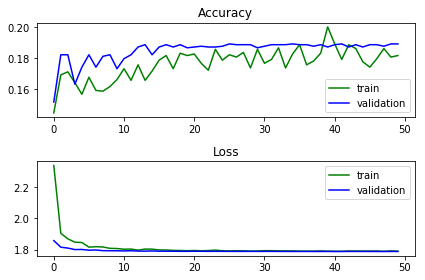

In [18]:
plt.subplot(211)
plt.title('Accuracy')
plt.plot(history.history['acc'], color='g', label='train')
plt.plot(history.history['val_acc'], color='b', label='validation')
plt.legend(loc='best')

plt.subplot(212)
plt.title('Loss')
plt.plot(history.history['loss'], color='g', label='train')
plt.plot(history.history['val_loss'], color='b', label='validation')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


### Print some of the predicted sample values from the trained network

In [22]:
ytest = np.argmax(Ytest, axis=1)
ytest_ = model.predict([Xqtest, Xstest])


array([21,  5,  5, ..., 10, 21, 19])